# **Linear & Non-Linear Models - Final Project:**
# Predicting Used Car Prices
### Group Members: Luke Schwenke, Tyler Roth, Sid Ramesh, John Wang
### Date: March 9, 2023

# **Import Packages**

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm
import os
from sklearn.metrics import (confusion_matrix, 
                           accuracy_score)
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn import tree
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sea

## **Load Used Car Dataset**

In [4]:
#from google.colab import drive
#drive.mount('/content/drive')

In [5]:
os.getcwd()

'/content'

In [6]:
train = pd.read_csv('/content/train.csv')
test =  pd.read_csv('/content/test.csv')

# Combine the pre-split datasets, we will re-split into train-test later
df = pd.concat([train, test])

# Remove NA
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna()

# Create a dopy of the original combined dataset
df_orig = df.copy()

In [7]:
df.head(2)

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,45654403,13328.0,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,44731507,16621.0,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8


# **Exploratory Data Analysis**

In [8]:
print('There are', df.columns.sort_values().shape[0], 'columns in this dataset. The columns are:\n\n', df.columns.sort_values().values)

print('\n\n This dataset has', len(df), 'rows')

There are 18 columns in this dataset. The columns are:

 ['Airbags' 'Category' 'Color' 'Cylinders' 'Doors' 'Drive wheels'
 'Engine volume' 'Fuel type' 'Gear box type' 'ID' 'Leather interior'
 'Levy' 'Manufacturer' 'Mileage' 'Model' 'Price' 'Prod. year' 'Wheel']


 This dataset has 19237 rows


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19237 entries, 0 to 19236
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                19237 non-null  int64  
 1   Price             19237 non-null  float64
 2   Levy              19237 non-null  object 
 3   Manufacturer      19237 non-null  object 
 4   Model             19237 non-null  object 
 5   Prod. year        19237 non-null  int64  
 6   Category          19237 non-null  object 
 7   Leather interior  19237 non-null  object 
 8   Fuel type         19237 non-null  object 
 9   Engine volume     19237 non-null  object 
 10  Mileage           19237 non-null  object 
 11  Cylinders         19237 non-null  float64
 12  Gear box type     19237 non-null  object 
 13  Drive wheels      19237 non-null  object 
 14  Doors             19237 non-null  object 
 15  Wheel             19237 non-null  object 
 16  Color             19237 non-null  object

In [10]:
# Check NULL values
train.isnull().sum()

ID                  0
Price               0
Levy                0
Manufacturer        0
Model               0
Prod. year          0
Category            0
Leather interior    0
Fuel type           0
Engine volume       0
Mileage             0
Cylinders           0
Gear box type       0
Drive wheels        0
Doors               0
Wheel               0
Color               0
Airbags             0
dtype: int64

<AxesSubplot:>

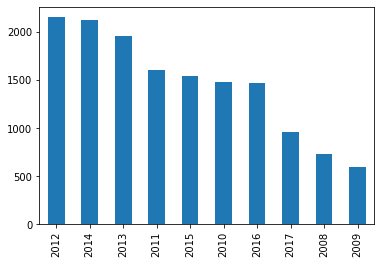

In [11]:
train['Prod. year'].value_counts().head(10).plot.bar()

<AxesSubplot:xlabel='Prod. year', ylabel='Price'>

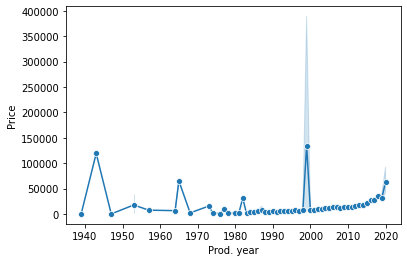

In [12]:
sea.lineplot(x='Prod. year',y='Price',marker='o',data=train)

In [13]:
train['Price'].describe() # not sure why there's some cars sold worth $1. Lets just filter to above $1k 

count    1.923700e+04
mean     1.855593e+04
std      1.905813e+05
min      1.000000e+00
25%      5.331000e+03
50%      1.317200e+04
75%      2.207500e+04
max      2.630750e+07
Name: Price, dtype: float64

In [14]:
train = train.loc[train.Price >1000,:]

Text(0, 0.5, 'Count')

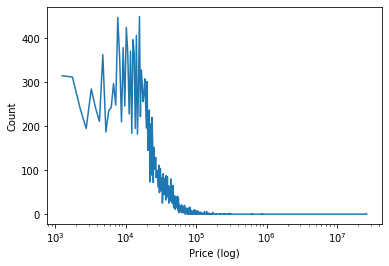

In [15]:
counts,edges = np.histogram(train['Price'], bins= int((np.max(train.Price) - np.min(train.Price))/500))
cent = (edges[:-1] + edges[1:])/2
plt.plot(cent,counts)
#plt.yscale('log')
plt.xscale('log')
plt.xlabel("Price (log)")
plt.ylabel("Count")

Text(0.5, 1.0, 'Top 5 Manufacturers by mean price')

<Figure size 720x1440 with 0 Axes>

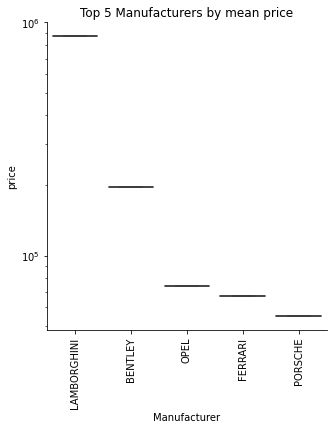

In [16]:
plt.figure(figsize = (10,20))
top10_manufac = train.groupby(['Manufacturer'])['Price'].mean().reset_index(name = 'price').sort_values(['price'],ascending = False).head(5)# top 5 manufacturers by mean price
g = sea.catplot(x = 'Manufacturer',y = 'price',data = top10_manufac,kind = 'box')
plt.yscale('log')
g.set_xticklabels(rotation=90)
plt.title("Top 5 Manufacturers by mean price")

Text(0.5, 1.0, 'Top 5 Models by mean price')

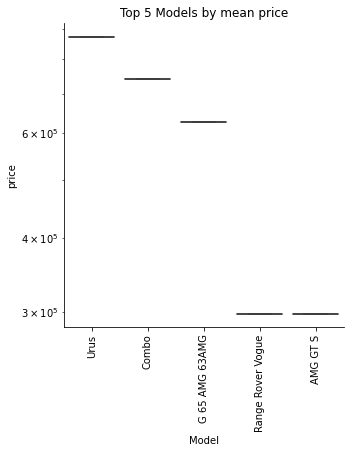

In [17]:
top10_model = train.groupby(['Model'])['Price'].mean().reset_index(name = 'price').sort_values(['price'],ascending = False).head(5) # top 5 mean model prices
g = sea.catplot(x = 'Model',y = 'price',data = top10_model,kind = 'box')
plt.yscale('log')
g.set_xticklabels(rotation=90)
plt.title("Top 5 Models by mean price")

Text(0.5, 1.0, 'Top 5 Categories by mean price')

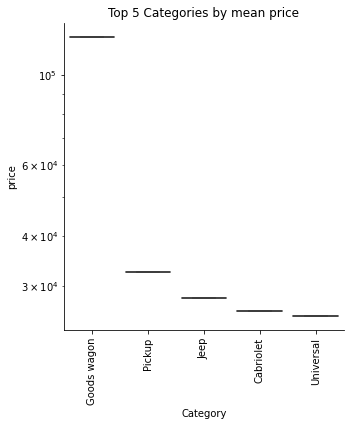

In [18]:
top10_cat = train.groupby(['Category'])['Price'].mean().reset_index(name = 'price').sort_values(['price'],ascending = False).head(5) # top 5 cats by mean price
g = sea.catplot(x = 'Category',y = 'price',data = top10_cat,kind = 'box')
g.set_xticklabels(rotation=90)
plt.yscale('log')
plt.title("Top 5 Categories by mean price")

<AxesSubplot:xlabel='Category', ylabel='Price'>

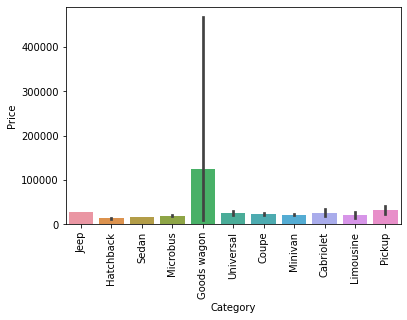

In [19]:
plt.xticks(rotation=90)
sea.barplot(x='Category',y='Price',data=train)

<AxesSubplot:>

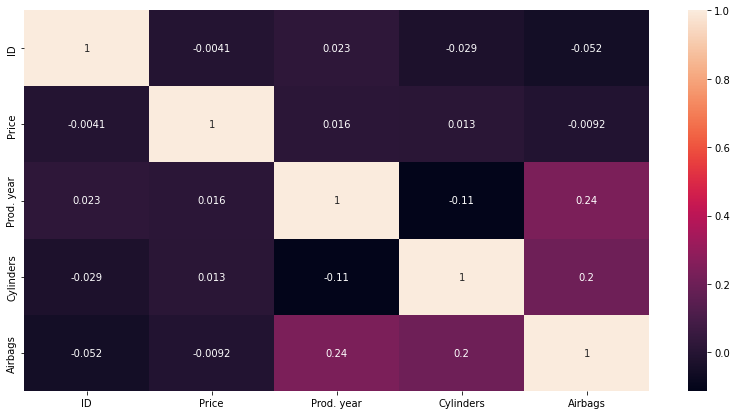

In [20]:
# Correlations
plt.figure(figsize=(14,7))
sea.heatmap(train.corr(),annot=True)

# **Apply Transformations, Encoding (Label/Dummy) and Feature Engineering**

In [21]:
df

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,45654403,13328.0,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,44731507,16621.0,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8
2,45774419,8467.0,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,04-May,Right-hand drive,Black,2
3,45769185,3607.0,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,4x4,04-May,Left wheel,White,0
4,45809263,11726.0,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Front,04-May,Left wheel,Silver,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19232,45798355,8467.0,-,MERCEDES-BENZ,CLK 200,1999,Coupe,Yes,CNG,2.0 Turbo,300000 km,4.0,Manual,Rear,02-Mar,Left wheel,Silver,5
19233,45778856,15681.0,831,HYUNDAI,Sonata,2011,Sedan,Yes,Petrol,2.4,161600 km,4.0,Tiptronic,Front,04-May,Left wheel,Red,8
19234,45804997,26108.0,836,HYUNDAI,Tucson,2010,Jeep,Yes,Diesel,2,116365 km,4.0,Automatic,Front,04-May,Left wheel,Grey,4
19235,45793526,5331.0,1288,CHEVROLET,Captiva,2007,Jeep,Yes,Diesel,2,51258 km,4.0,Automatic,Front,04-May,Left wheel,Black,4


In [22]:
# Remove 'ID' column since this does not have value
df = df.drop('ID', axis=1)
df = df.drop('Model', axis=1)

In [23]:
# Set Mileage to numeric
df['Mileage'] = df['Mileage'].str.replace('km', '')
df['Mileage'] = df['Mileage'].str.strip()
df['Mileage'] = pd.to_numeric(df['Mileage'])

In [24]:
# Set Levy to numeric
df['Levy'] = pd.to_numeric(df['Levy'], errors='coerce')
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna()

In [25]:
# Create a new column that captures the car's age
import datetime
current_year = datetime.date.today().year
df['Car age'] = current_year - train['Prod. year']

In [26]:
# Create Age bucket
choices = ['New', 'Slightly New', 'Old', 'Antique']

conditions = [
       (df['Car age'] <= 5), 
       (df['Car age'] <= 10),
       (df['Car age'] <= 20),
       (df['Car age'] > 20)]
df['Age bucket'] = np.select(conditions, choices, default='Old')

In [27]:
# Select all columns that are object data types (non-float and non-integer)
categorical_vars = df.select_dtypes(include='O')
categorical_vars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13418 entries, 0 to 19236
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Manufacturer      13418 non-null  object
 1   Category          13418 non-null  object
 2   Leather interior  13418 non-null  object
 3   Fuel type         13418 non-null  object
 4   Engine volume     13418 non-null  object
 5   Gear box type     13418 non-null  object
 6   Drive wheels      13418 non-null  object
 7   Doors             13418 non-null  object
 8   Wheel             13418 non-null  object
 9   Color             13418 non-null  object
 10  Age bucket        13418 non-null  object
dtypes: object(11)
memory usage: 1.2+ MB


In [28]:
# Create label encoder instance
le = LabelEncoder()
for_label_encoding = categorical_vars[['Engine volume', 'Age bucket']]
encode = list(for_label_encoding)

# Variables for Label or Dummy encoding
for_label_encoding = categorical_vars[['Engine volume', 'Age bucket']]

for_dummy_encoding = list(categorical_vars[['Manufacturer', 'Category', 'Leather interior',  # Took out model
                                       'Fuel type', 'Gear box type', 'Wheel', 'Color', 'Drive wheels', 'Doors']].columns)

# NOTE: dummy variables should have binary columns for their unique categorical values since these variables do not have an order/hierarchy.
# We can just label encode (0,1,2,3, etc.) in the column for variables with order such as the Age bucket (old, new, antique, etc.)


In [29]:

# Label encode ordered variables
df[encode] = df[encode].apply(lambda col: le.fit_transform(col))
df[encode]

# Dummy encode non-ordered variables
df_with_dummies = pd.get_dummies(df, columns=for_dummy_encoding)

In [30]:
# Update the df to have the dummies included
df = df_with_dummies.copy()
len(df.columns)

104

In [31]:
print("Before dummy encoding categorical variables with no heirarchy, there were", len(df_orig.columns), "columns")

print("After dummy encoding there are now", len(df_with_dummies.columns), "columns")

Before dummy encoding categorical variables with no heirarchy, there were 18 columns
After dummy encoding there are now 104 columns


# **Train-Test-Split**

In [32]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('Price', axis=1), df['Price'], test_size=0.3, random_state=777)

# print the shape of the training and testing sets
print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

Training set shape: (9392, 103)
Testing set shape: (4026, 103)


# **Linear Regression**

In [46]:
import statsmodels.api as sm

df_linear = df[df.Price > 1000]
df.head(15)

,Price,Levy,Prod. year,Engine volume,Mileage,Cylinders,Airbags,Car age,Age bucket,Manufacturer_ACURA,...,Color_Silver,Color_Sky blue,Color_White,Color_Yellow,Drive wheels_4x4,Drive wheels_Front,Drive wheels_Rear,Doors_02-Mar,Doors_04-May,Doors_>5
0,13328.0,1399.0,2010,52,186005,6.0,12,13.0,2,0,...,1,0,0,0,1,0,0,0,1,0
1,16621.0,1018.0,2011,47,192000,6.0,8,12.0,2,0,...,0,0,0,0,1,0,0,0,1,0
3,3607.0,862.0,2011,37,168966,4.0,0,12.0,2,0,...,0,0,1,0,1,0,0,0,1,0
4,11726.0,446.0,2014,13,91901,4.0,4,9.0,3,0,...,1,0,0,0,0,1,0,0,1,0
5,39493.0,891.0,2016,27,160931,4.0,4,7.0,3,0,...,0,0,1,0,0,1,0,0,1,0
6,1803.0,761.0,2010,23,258909,4.0,12,13.0,2,0,...,0,0,1,0,0,1,0,0,1,0
7,549.0,751.0,2013,35,216118,4.0,12,NaN,2,0,...,0,0,0,0,0,1,0,0,1,0
8,1098.0,394.0,2014,37,398069,4.0,12,9.0,3,0,...,0,0,0,0,0,1,0,0,1,0
10,941.0,1053.0,2014,52,184467,6.0,12,NaN,2,0,...,0,0,1,0,0,0,1,0,1,0
13,1019.0,1055.0,2013,52,138038,6.0,12,10.0,3,0,...,0,0,1,0,0,1,0,0,1,0


# **Gamma Regression**

In [34]:
import statsmodels.api as sm
df_gamma = df[df.Price > 1000]
df_gamma = df_gamma.dropna()
gamma_predictors = df_gamma.drop('Price', axis=1)
gamma_predictors_c = sm.add_constant(gamma_predictors)
gamma_target = df_gamma['Price']

In [35]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(gamma_predictors)
scaler_c = preprocessing.StandardScaler().fit(gamma_predictors_c)
gamma_pred_scaled  = scaler.transform(gamma_predictors)
gamma_pred_scaled_c  = scaler_c.transform(gamma_predictors_c)

In [36]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import GammaRegressor

gam_fit = GammaRegressor(max_iter = 5000)
gam_rfecv = RFECV(estimator=gam_fit, step=1, cv=10, scoring='explained_variance')
gam_rfecv.fit(gamma_pred_scaled, gamma_target)

RFECV(cv=10, estimator=GammaRegressor(max_iter=5000),
      scoring='explained_variance')

In [37]:
print('Optimal number of features: {}'.format(gam_rfecv.n_features_))

Optimal number of features: 101


In [38]:
gamma_model = sm.GLM(gamma_target, sm.add_constant(gamma_predictors.loc[:,gam_rfecv.support_]), family = sm.families.family.Gamma(sm.families.links.log()))
gamma_results = gamma_model.fit()


In [39]:
gamma_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  Price   No. Observations:                11222
Model:                            GLM   Df Residuals:                    11130
Model Family:                   Gamma   Df Model:                           91
Link Function:                    log   Scale:                         0.51079
Method:                          IRLS   Log-Likelihood:            -1.2035e+05
Date:                Mon, 06 Mar 2023   Deviance:                       6098.3
Time:                        23:41:42   Pearson chi2:                 5.69e+03
No. Iterations:                   100   Pseudo R-squ. (CS):             0.3059
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                      -3.265e-07   1.33e-06     -0.246      0.806   -2.93e-06    2.28e-06
Levy                           0.0005   2.37e-05     21.663      0.000       0.000       0.001
Prod. year                     0.0045   5.42e-05     82.926      0.000       0.004       0.005
Engine volume                 -0.0024      0.001     -2.213      0.027      -0.005      -0.000
Mileage                    -3.798e-10   3.06e-10     -1.239      0.215    -9.8e-10    2.21e-10
Cylinders                      0.0379      0.012      3.158      0.002       0.014       0.061
Airbags                       -0.0356      0.002    -17.508      0.000      -0.040      -0.032
Car age                       -0.0080      0.003     -3.035      0.002      -0.013      -0.003
Age bucket                     0.0709      0.012      5.801      0.000       0.047       0.095
Manufacturer_ACURA            -0.6345      0.227     -2.797      0.005      -1.079      -0.190
Manufacturer_AUDI             -0.1923      0.085     -2.274      0.023      -0.358      -0.027
Manufacturer_BENTLEY           1.4923      0.703      2.123      0.034       0.114       2.870
Manufacturer_BMW              -0.0639      0.062     -1.033      0.302      -0.185       0.057
Manufacturer_BUICK            -0.4187      0.208     -2.013      0.044      -0.826      -0.011
Manufacturer_CADILLAC         -0.5537      0.254     -2.178      0.029      -1.052      -0.056
Manufacturer_CHEVROLET        -0.0700      0.055     -1.277      0.202      -0.177       0.037
Manufacturer_CHRYSLER         -0.9300      0.208     -4.462      0.000      -1.338      -0.521
Manufacturer_CITROEN           0.0066      0.319      0.021      0.984      -0.619       0.632
Manufacturer_DAEWOO           -0.6238      0.091     -6.880      0.000      -0.802      -0.446
Manufacturer_DAIHATSU         -0.4694      0.511     -0.919      0.358      -1.470       0.531
Manufacturer_DODGE            -0.9815      0.118     -8.304      0.000      -1.213      -0.750
Manufacturer_FERRARI          -0.0854      0.504     -0.169      0.866      -1.074       0.903
Manufacturer_FIAT             -0.8252      0.126     -6.562      0.000      -1.072      -0.579
Manufacturer_FORD              0.4870      0.057      8.484      0.000       0.374       0.600
Manufacturer_GMC              -1.0006      0.208     -4.801      0.000      -1.409      -0.592
Manufacturer_HONDA             0.3569      0.059      6.003      0.000       0.240       0.473
Manufacturer_HYUNDAI           0.2996      0.052      5.758      0.000       0.198       0.402
Manufacturer_INFINITI         -0.6660      0.292     -2.279      0.023      -1.239      -0.093
Manufacturer_JAGUAR            0.6502      0.165      3.940      0.000       0.327       0.974
Manufacturer_JEEP              0.3332      

In [40]:
prediction = gam_rfecv.predict(gamma_pred_scaled)
residual = (gamma_target- gam_rfecv.predict(gamma_pred_scaled))
mean_error_rate_gamma = np.mean((gamma_target-prediction)**2)

In [41]:
X_train, X_test, y_train, y_test = train_test_split(gamma_predictors.loc[:,gam_rfecv.support_], gamma_target, test_size=0.3, random_state=10)
gamma_cols = gamma_predictors.loc[:,gam_rfecv.support_].columns
scaler = StandardScaler().fit(X_train[gamma_cols]) 

X_train[gamma_cols] = scaler.transform(X_train[gamma_cols])

X_test[gamma_cols] = scaler.transform(X_test[gamma_cols])

In [42]:
gam_fit.fit(X_train, y_train)

print('R squared training set', round(gam_fit.score(X_train, y_train)*100, 2))
print('R squared test set', round(gam_fit.score(X_test, y_test)*100, 2))

R squared training set 32.85
R squared test set 27.79


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but GammaRegressor was fitted with feature names
  warnings.warn(


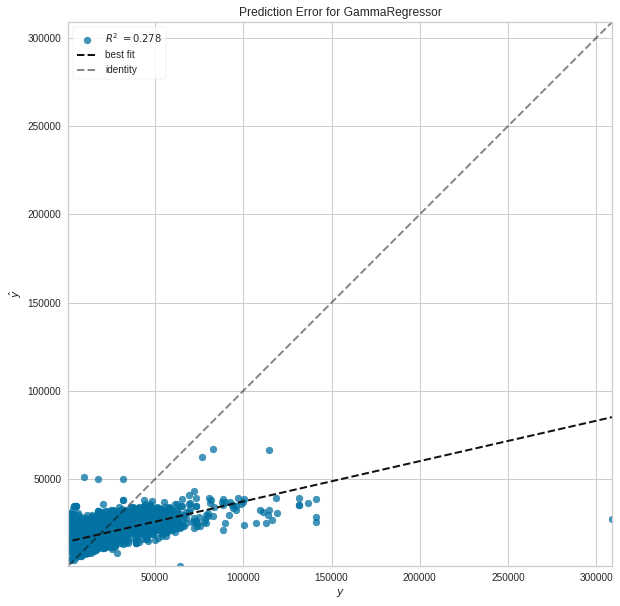

<AxesSubplot:title={'center':'Prediction Error for GammaRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [43]:
from yellowbrick.regressor import PredictionError, ResidualsPlot
fig,ax = plt.subplots(1,1,figsize = (20,10))
visualizer = PredictionError(gam_fit,ax = ax)
visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test)  
visualizer.poof()

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but GammaRegressor was fitted with feature names
  warnings.warn(


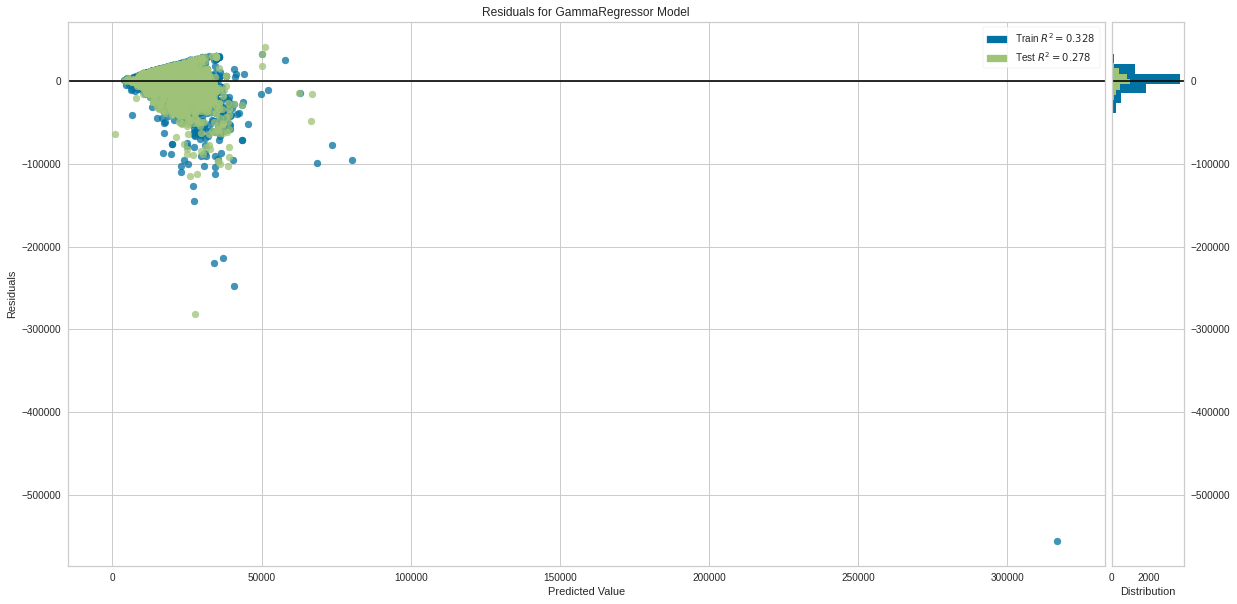

<AxesSubplot:title={'center':'Residuals for GammaRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [44]:
fig,ax = plt.subplots(1,1,figsize = (20,10))
visualizer = ResidualsPlot(gam_fit,ax = ax)
visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test)  
visualizer.poof()

Text(0.5, 1.0, 'Gamma Regression Best Fit vs Predicted Values')

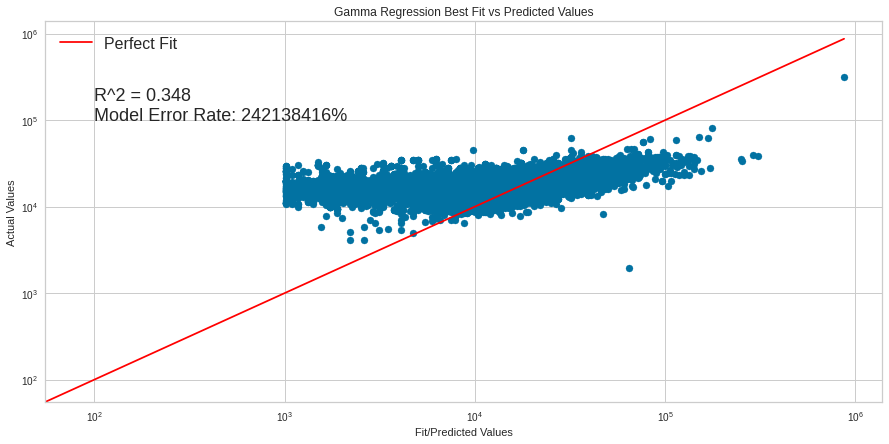

In [45]:
fig,ax = plt.subplots(1,1,figsize = (15,7))
plt.rcParams.update({'font.size': 18})
ax.scatter(gamma_target,prediction)
ax.plot(np.linspace(0,np.max(gamma_target),10000),np.linspace(0,np.max(gamma_target),10000),color = 'red',label = 'Perfect Fit')
ax.set_ylabel("Actual Values")
ax.set_xlabel("Fit/Predicted Values")
ax.set_yscale('log')
ax.set_xscale('log')
plt.legend(prop={'size': 16})
ax.text(100,1e5,f'R^2 = {0.348}\nModel Error Rate: {round(mean_error_rate_gamma)}%')
ax.set_title("Gamma Regression Best Fit vs Predicted Values")

# **Log Linear Regression and Log Transformed Regression**


In [47]:
df1 = df
df1 = df1[~(df1['Price']<=1000)]

X_train, X_test, y_train, y_test = train_test_split(df1.drop('Price', axis=1), df1['Price'], test_size=0.3, random_state=222)
df1.head()  
#len(y_test)
#len(X_test)

,Price,Levy,Prod. year,Engine volume,Mileage,Cylinders,Airbags,Car age,Age bucket,Manufacturer_ACURA,...,Color_Silver,Color_Sky blue,Color_White,Color_Yellow,Drive wheels_4x4,Drive wheels_Front,Drive wheels_Rear,Doors_02-Mar,Doors_04-May,Doors_>5
0,13328.0,1399.0,2010,52,186005,6.0,12,13.0,2,0,...,1,0,0,0,1,0,0,0,1,0
1,16621.0,1018.0,2011,47,192000,6.0,8,12.0,2,0,...,0,0,0,0,1,0,0,0,1,0
3,3607.0,862.0,2011,37,168966,4.0,0,12.0,2,0,...,0,0,1,0,1,0,0,0,1,0
4,11726.0,446.0,2014,13,91901,4.0,4,9.0,3,0,...,1,0,0,0,0,1,0,0,1,0
5,39493.0,891.0,2016,27,160931,4.0,4,7.0,3,0,...,0,0,1,0,0,1,0,0,1,0


In [48]:
#Create Test Train Splits

X_train1 = X_train.apply(pd.to_numeric, errors='coerce')
X_test1 = X_test.apply(pd.to_numeric, errors = 'coerce')
Y_train1 = y_train.apply(pd.to_numeric, errors='coerce')
Y_test1 = y_test.apply(pd.to_numeric, errors='coerce')
X_train1.fillna(0, inplace=True)
X_test1.fillna(0, inplace=True)
Y_train1.fillna(0, inplace=True)
Y_test1.fillna(0, inplace=True)
X_log_train = np.log(X_train1+1)
X_log_test = np.log(X_test1+1)
Y_log_train = np.log(Y_train1+1)
Y_log_test = np.log(Y_test1+1)


<Figure size 720x1080 with 0 Axes>

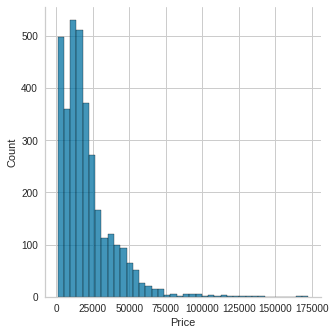

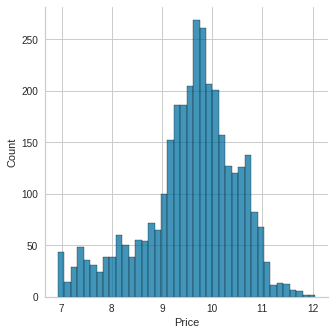

In [49]:
import seaborn as sns
plt.figure(figsize=(10,15))
sns.displot(Y_test1, bins = 40)
sns.displot(Y_log_test, bins = 40)
plt.show() 



In [50]:
#Linear Regression R^2
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg1 = LinearRegression().fit(X_train1, Y_train1)
linreg2 = LinearRegression().fit(X_test1, Y_test1)
r_sq1 = linreg1.score(X_train1, Y_train1)
r_sq2 = linreg1.score(X_test1, Y_test1)
print(f"coefficient of determination: {r_sq1}")
print(f"coefficient of determination: {r_sq2}")

coefficient of determination: 0.5422693812939736
coefficient of determination: 0.37728382411487604


In [51]:
#Log Linear Regression
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
logreg1 = LinearRegression()
logreg1.fit(X_log_train, Y_train1)
logreg2 = LinearRegression()
logreg2.fit(X_log_test, Y_test1)
r_sq1 = logreg1.score(X_log_train, Y_train1)
r_sq2 = logreg1.score(X_log_test, Y_test1)
print(f"coefficient of determination: {r_sq1}")
print(f"coefficient of determination: {r_sq2}")

coefficient of determination: 0.5293377543519711
coefficient of determination: 0.37760156382823584


In [52]:
#Log Transformed Response
logreg3 = LinearRegression()
logreg3.fit(X_train1, Y_log_train)
logreg4 = LinearRegression()
logreg4.fit(X_test1, Y_log_test)
r_sq3 = logreg3.score(X_train1, Y_log_train)
r_sq4 = logreg3.score(X_test1, Y_log_test)
print(f"coefficient of determination: {r_sq3}")
print(f"coefficient of determination: {r_sq4}")

coefficient of determination: 0.37850622161554526
coefficient of determination: 0.34695051455690196


In [53]:
#Linear Models Results Analysis
lin_y_pred = linreg1.predict(X_test1)
loglin_y_pred = logreg1.predict(X_log_test)
logtrans_y_pred = logreg3.predict(X_test1)

percent_error=pd.DataFrame(columns=['lin_y_error', 'loglin_y_error', 'logtrans_y_error'])
percent_error['lin_y_error'] = abs(lin_y_pred-Y_test1)/Y_test1
percent_error['loglin_y_error']= abs(loglin_y_pred-Y_test1)/Y_test1
percent_error['logtrans_y_error'] = abs(logtrans_y_pred-Y_log_test)/Y_test1
percent_error

percent_error.mean(axis=0)

lin_y_error         1.250562
loglin_y_error      1.309243
logtrans_y_error    0.000119
dtype: float64

In [54]:
from sklearn.metrics import mean_squared_error
from math import sqrt
lin_y_pred = linreg1.predict(X_test1)
loglin_y_pred = logreg1.predict(X_log_test)
logtrans_y_pred = logreg3.predict(X_test1)
rms_linear = sqrt(mean_squared_error(Y_test1, lin_y_pred))
rms_loglin =sqrt(mean_squared_error(Y_test1, loglin_y_pred))
rms_logtrans =np.sqrt(mean_squared_error(np.exp(Y_log_test),np.exp(logtrans_y_pred)))
print("The RMSE for the Linear Regression is", rms_linear)
print("The RMSE for the Log Linear Regression is", rms_loglin)
print("The RMSE for the Log Transformed Linear Regression is", rms_logtrans)


The RMSE for the Linear Regression is 13809.89625416884
The RMSE for the Log Linear Regression is 13806.372568317911
The RMSE for the Log Transformed Linear Regression is 14868.518600947356


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


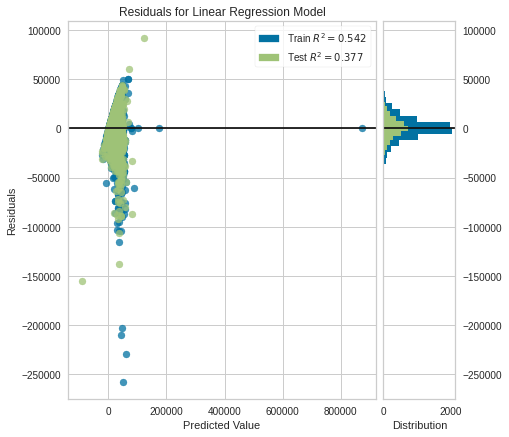

<AxesSubplot:title={'center':'Residuals for Linear Regression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [55]:
#Residuals Plot for Linear Regression
from yellowbrick.datasets import load_concrete
from yellowbrick.regressor import ResidualsPlot
visualizer = ResidualsPlot(linreg1, size = (500,500), title = "Residuals for Linear Regression Model")
visualizer.fit(X_train1, Y_train1)
visualizer.score(X_test1, Y_test1)
visualizer.show()

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


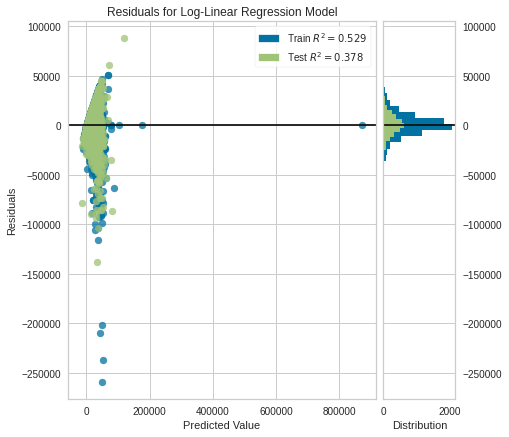

<AxesSubplot:title={'center':'Residuals for Log-Linear Regression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [56]:
#Residuals Plot for Log Linear Regression
visualizer = ResidualsPlot(logreg1, size = (500,500), title = "Residuals for Log-Linear Regression Model")
visualizer.fit(X_log_train, Y_train1)
visualizer.score(X_log_test, Y_test1)
visualizer.show()

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


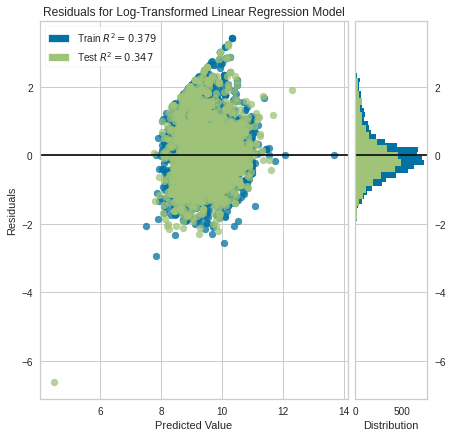

<AxesSubplot:title={'center':'Residuals for Log-Transformed Linear Regression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [57]:
#Residuals Plot for Log Linear Regression
visualizer = ResidualsPlot(logreg3, size = (500,500), title = "Residuals for Log-Transformed Linear Regression Model")
visualizer.fit(X_train1, Y_log_train)
visualizer.score(X_test1, Y_log_test)
visualizer.show()

# **Lasso Regression**

Text(0, 0.5, 'Count')

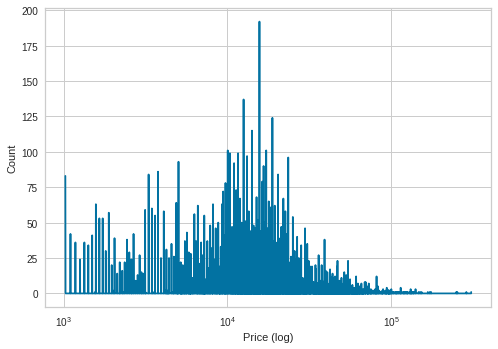

In [58]:
counts,edges = np.histogram(df[(df.Price > 1000) & (df.Price < 500000)].Price.values, bins= int((np.max(train.Price) - np.min(train.Price))/250))
cent = (edges[:-1] + edges[1:])/2
plt.plot(cent,counts)
#plt.yscale('log')
plt.xscale('log')
plt.xlabel("Price (log)")
plt.ylabel("Count")

In [59]:
from sklearn import preprocessing

df_lasso = df[(df.Price > 1000) & (df.Price < 500000)]
lasso_predictors = df_lasso.drop('Price', axis=1)
lasso_target = df_lasso['Price']

list_numerical = lasso_predictors.columns
X_train, X_test, y_train, y_test = train_test_split(lasso_predictors, lasso_target, test_size=0.3, random_state=10)

scaler = StandardScaler().fit(X_train[list_numerical]) 

X_train[list_numerical] = scaler.transform(X_train[list_numerical])

X_test[list_numerical] = scaler.transform(X_test[list_numerical])

In [60]:
from sklearn.linear_model import Lasso

reg = Lasso(alpha=1)
reg.fit(X_train, y_train)

print('R squared training set', round(reg.score(X_train, y_train)*100, 2))
print('R squared test set', round(reg.score(X_test, y_test)*100, 2))

R squared training set 41.88
R squared test set 35.77


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.345e+10, tolerance: 2.423e+08
  model = cd_fast.enet_coordinate_descent(


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.335e+10, tolerance: 2.423e+08
  model = cd_fast.enet_coordinate_descent(


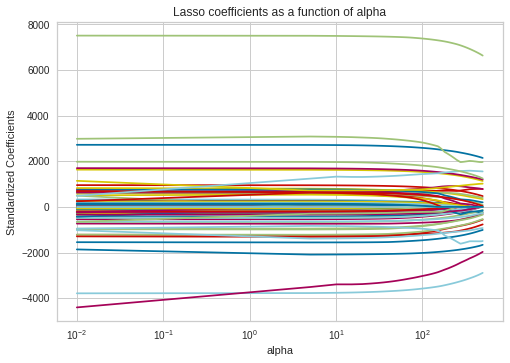

In [61]:
# at alpha = 0 this is just multilinear regression

alphas = np.linspace(0.01,500,100)
lasso = Lasso(max_iter=10000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)

ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Standardized Coefficients')
plt.title('Lasso coefficients as a function of alpha');

In [62]:
from sklearn.linear_model import LassoCV

# Lasso with 5 fold cross-validation
model = LassoCV(cv=5, random_state=0, max_iter=10000)

# Fit model
model.fit(X_train, y_train)

LassoCV(cv=5, max_iter=10000, random_state=0)

In [63]:
lasso_best = Lasso(alpha=model.alpha_) # best performing alpha with cross validation
lasso_best.fit(X_train, y_train)

Lasso(alpha=69.69206153868363)

In [64]:
print('R squared training set', round(lasso_best.score(X_train, y_train)*100, 2))
print('R squared test set', round(lasso_best.score(X_test, y_test)*100, 2))

R squared training set 41.74
R squared test set 35.72


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but Lasso was fitted with feature names
  warnings.warn(


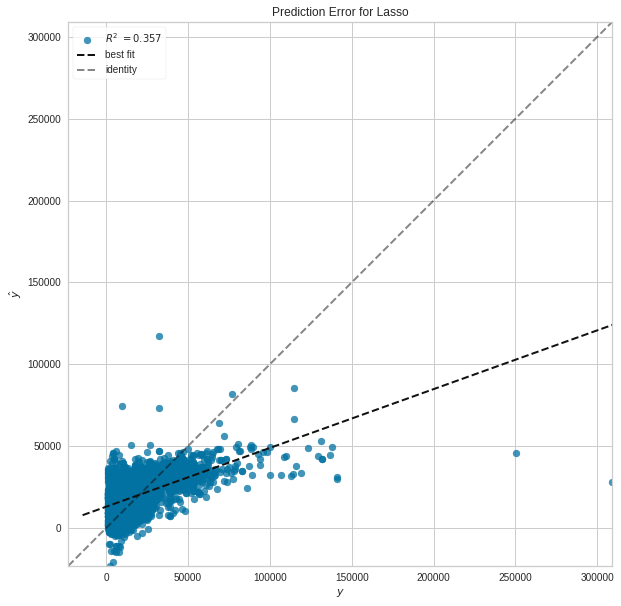

In [65]:
from yellowbrick.regressor import PredictionError, ResidualsPlot
fig,ax = plt.subplots(1,1,figsize = (20,10))
visualizer = PredictionError(lasso_best,ax = ax)
visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test)  
visualizer.poof()
x = ax.get_xlim()
y = ax.get_ylim()

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but Lasso was fitted with feature names
  warnings.warn(


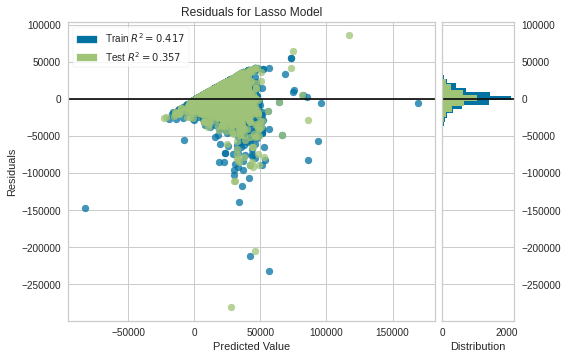

<AxesSubplot:title={'center':'Residuals for Lasso Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [66]:
model2 = Lasso()
visualizer = ResidualsPlot(lasso_best)
visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test)  
visualizer.poof()

In [67]:
lasso_predictions = lasso_best.predict( scaler.transform(lasso_predictors))
mean_error_rate_lasso = np.mean(abs(lasso_target-lasso_predictions)/lasso_target)*100

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but Lasso was fitted with feature names
  warnings.warn(


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but Lasso was fitted with feature names
  warnings.warn(


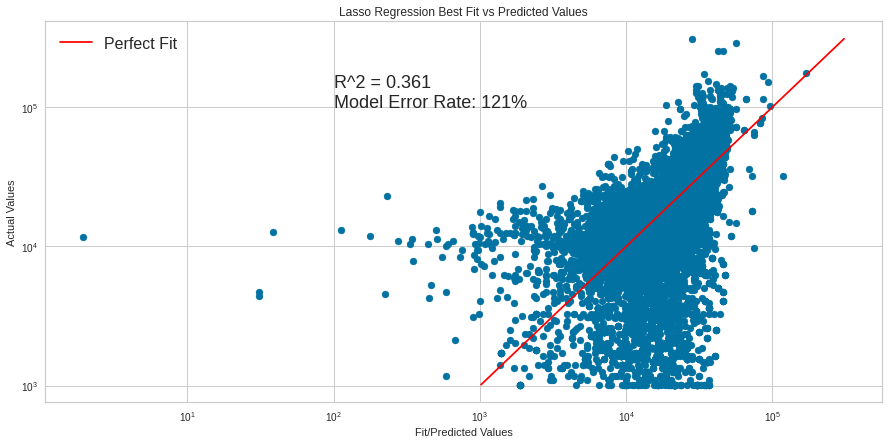

In [68]:

fig,ax = plt.subplots(1,1,figsize = (15,7))
plt.rcParams.update({'font.size': 18})
ax.scatter(lasso_best.predict( scaler.transform(lasso_predictors)),lasso_target)
ax.plot(np.linspace(np.min(lasso_target),np.max(lasso_target),10000),np.linspace(np.min(lasso_target),np.max(lasso_target),10000),color = 'red',label = 'Perfect Fit')
ax.set_ylabel("Actual Values")
ax.set_xlabel("Fit/Predicted Values")
ax.set_yscale('log')
ax.set_xscale('log')
ax.text(100,1e5,f'R^2 = {0.361}\nModel Error Rate: {round(mean_error_rate_lasso)}%')
ax.set_title("Lasso Regression Best Fit vs Predicted Values")
plt.legend(prop={'size': 16})

# **Inverse Gaussian [Not Used, Just Tested]**

In [ ]:
import numpy as np
from scipy.stats import invgauss
import matplotlib.pyplot as plt

In [ ]:
import statsmodels.api as sm

#df_ig = df[df.Price > 1000]

# Remove NA and Inf
df_ig = df.copy()
df_ig = df_ig.replace([np.inf, -np.inf], np.nan)
df_ig = df_ig.dropna()

ig_predictors = sm.add_constant(df_ig.drop('Price', axis=1))
#ig_predictors = df_ig.drop('Price', axis=1)
ig_target = df_ig['Price']

In [ ]:
ig_predictors.columns[ig_predictors.isna().any()].tolist()

[]

In [ ]:
# Scale Data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
ig_predictors_scaled = scaler.fit_transform(ig_predictors)

In [ ]:
ig_predictors

,const,Levy,Prod. year,Engine volume,Mileage,Cylinders,Airbags,Car age,Age bucket,Manufacturer_ACURA,...,Color_Silver,Color_Sky blue,Color_White,Color_Yellow,Drive wheels_4x4,Drive wheels_Front,Drive wheels_Rear,Doors_02-Mar,Doors_04-May,Doors_>5
0,1.0,1399.0,2010,63,186005,6.0,12,13.0,2,0,...,1,0,0,0,1,0,0,0,1,0
1,1.0,1018.0,2011,56,192000,6.0,8,12.0,2,0,...,0,0,0,0,1,0,0,0,1,0
3,1.0,862.0,2011,46,168966,4.0,0,12.0,2,0,...,0,0,1,0,1,0,0,0,1,0
4,1.0,446.0,2014,22,91901,4.0,4,9.0,3,0,...,1,0,0,0,0,1,0,0,1,0
5,1.0,891.0,2016,36,160931,4.0,4,7.0,3,0,...,0,0,1,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19227,1.0,1053.0,2014,63,219030,6.0,12,9.0,3,0,...,0,0,0,0,1,0,0,0,1,0
19231,1.0,1055.0,2013,63,107800,6.0,12,10.0,3,0,...,0,0,0,0,0,0,1,0,1,0
19233,1.0,831.0,2011,44,161600,4.0,8,12.0,2,0,...,0,0,0,0,0,1,0,0,1,0
19234,1.0,836.0,2010,36,116365,4.0,4,13.0,2,0,...,0,0,0,0,0,1,0,0,1,0


# **Gradient Boosting:**

In [69]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Create a HistGradientBoostingRegressor object
reg = HistGradientBoostingRegressor(random_state=12)

# Train the regressor on the training data
reg.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = reg.predict(X_test)



/usr/local/lib/python3.8/dist-packages/sklearn/experimental/enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


In [70]:
from sklearn.metrics import r2_score

mse = mean_squared_error(y_test, y_pred)
print("Root Mean Squared Error:", np.sqrt(mse))

y_pred = reg.predict(X_train)
r2_train = r2_score(y_train, y_pred)
print("Train R-squared score:", r2_train)

y_pred = reg.predict(X_test)
r2_test = r2_score(y_test, y_pred)
print("Test R-squared score:", r2_test)

#n = len(y_test)
#mpe_test = np.mean(abs(y_test - y_pred) / y_test)*100
#print("Test Mean Percent Error:", mpe_test)

Root Mean Squared Error: 9791.801147925014
Train R-squared score: 0.8397266573575723
Test R-squared score: 0.7170453801642401


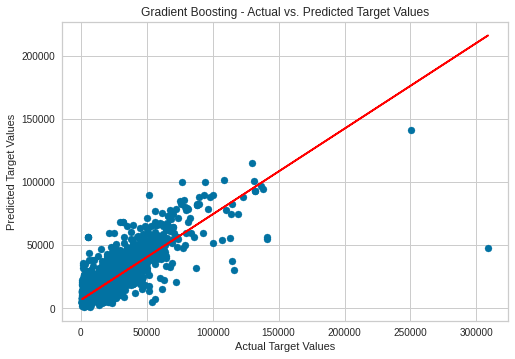

In [71]:
plt.scatter(y_test, y_pred)

# Calculate the slope and intercept of the best-fit line
slope, intercept = np.polyfit(y_test, y_pred, 1)

# Create a function that represents the best-fit line
line = slope * y_test + intercept

# Plot the best-fit line on top of the scatter plot
plt.plot(y_test, line, color='red')


# Set plot title and axis labels
plt.title("Gradient Boosting - Actual vs. Predicted Target Values")
plt.xlabel("Actual Target Values")
plt.ylabel("Predicted Target Values")

# Display the plot
plt.show()

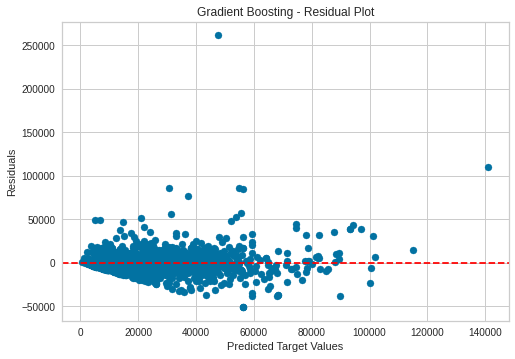

In [72]:
# Calculate the residuals
residuals = y_test - y_pred

# Plot the residuals against the predicted values
plt.scatter(y_pred, residuals)

# Add a horizontal line at y=0 to indicate zero residual
plt.axhline(y=0, color='red', linestyle='--')

# Set plot title and axis labels
plt.title("Gradient Boosting - Residual Plot")
plt.xlabel("Predicted Target Values")
plt.ylabel("Residuals")

# Display the plot
plt.show()

# **Random Forest**

In [73]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Create a random forest regression model
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model to the training data
rf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rf.predict(X_test)

# Evaluate the model's performance using mean squared error
mse = mean_squared_error(y_test, y_pred)
print("Root Mean Squared Error:", np.sqrt(mse))

Root Mean Squared Error: 9729.016487992878


In [74]:
# Implement with Random Search and Cross-Fold-Validation
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV

# Define the hyperparameter space to search over
#param_distributions = {
#    "n_estimators": np.arange(5, 100, 5),
#    "max_depth": [3, 5, 10],
#    "min_samples_split": np.arange(2, 10, 2),
#    "min_samples_leaf": np.arange(1, 10, 2)
#}

# Create a RandomForestRegressor object
rf = RandomForestRegressor(random_state=42, n_estimators=80, min_samples_split=2, min_samples_leaf=3, max_depth=10)
rf.fit(X_train, y_train)

# Create a RandomizedSearchCV object
#rs = RandomizedSearchCV(rf, param_distributions, n_iter=100, cv=5, scoring="neg_mean_squared_error", random_state=42) #root????

# Fit the RandomizedSearchCV object to the training data
#rs.fit(X_train, y_train)

# Get the best model and its parameters
#best_model = rs.best_estimator_
#best_params = rs.best_params_

# Make predictions on the test data using the best model
y_pred = rf.predict(X_test)

# Evaluate the performance of the model using mean squared error
mse = mean_squared_error(y_test, y_pred)
#print("Best Parameters:", best_params)
print("Root Mean Squared Error:", np.sqrt(mse))


Root Mean Squared Error: 10561.995896971655


In [75]:
from sklearn.metrics import r2_score

y_pred = rf.predict(X_train)
r2_train = r2_score(y_train, y_pred)
print("RF Train R-squared score:", r2_train)

y_pred = rf.predict(X_test)
r2_test = r2_score(y_test, y_pred)
print("RF Test R-squared score:", r2_test)

RF Train R-squared score: 0.8126248781171268
RF Test R-squared score: 0.670781973252964


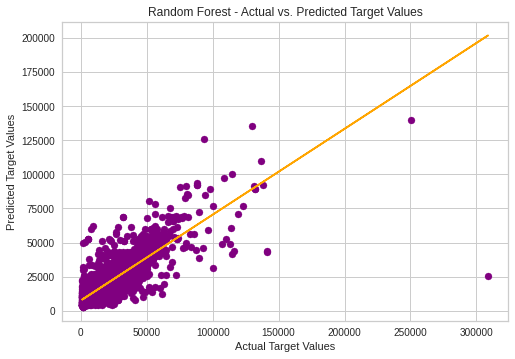

In [76]:
plt.scatter(y_test, y_pred, color="purple")

y_pred = rf.predict(X_test)

# Calculate the slope and intercept of the best-fit line
slope, intercept = np.polyfit(y_test, y_pred, 1)

# Create a function that represents the best-fit line
line = slope * y_test + intercept

# Plot the best-fit line on top of the scatter plot
plt.plot(y_test, line, color='orange')


# Set plot title and axis labels
plt.title("Random Forest - Actual vs. Predicted Target Values")
plt.xlabel("Actual Target Values")
plt.ylabel("Predicted Target Values")

# Display the plot
plt.show()